In [22]:
import os
import numpy as np
import pandas as pd
from pandarallel import pandarallel
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import DataStructs
from massspecgym.data.datasets import MassSpecDataset
from massspecgym.data.data_module import MassSpecDataModule
from massspecgym.utils import (
    morgan_fp, init_plotting, parse_paths_from_df, Tree, find_duplicate_smiles, add_identifiers, 
    MSnDataset, visualize_MSn_tree, smiles_to_scaffold, train_val_test_split, create_split_file
    )
%reload_ext autoreload
%autoreload 2

In [2]:
datasets_paths = ["datasets/20231031_nihnp_library_pos_all_lib_MSn.mgf",
                  "datasets/20231130_mcescaf_library_pos_all_lib_MSn.mgf",
                  "datasets/20231130_otavapep_library_pos_all_lib_MSn.mgf",
                  "datasets/20240411_mcebio_library_pos_all_lib_MSn.mgf"]

In [3]:
# merge datasets into a single mgf file
if os.path.exists("datasets/all_MSn_spectra.mgf"):
    print("merged mgf file already exists in datasets/all_MSn_spectra.mgf")
else:
    with open("datasets/all_MSn_spectra.mgf", "w") as outfile:
        for dataset_path in datasets_paths:
            print(dataset_path)
            with open(dataset_path, "r") as infile:
                for line in infile:
                    outfile.write(line)
                infile.close()
    print("merged mgf file was successfully created in datasets/all_MSn_spectra.mgf")

merged mgf file already exists in datasets/all_MSn_spectra.mgf


In [4]:
msn_dataset = MSnDataset(pth="datasets/all_MSn_spectra.mgf")
print(len(msn_dataset))

16476


In [6]:
msn_dataset.metadata.to_csv("datasets/all_MSn_spectra.csv")

In [7]:
# basic data analysis
"""all_trees = {}
all_smiles = {}
# create trees from all mgf files
for dataset_path in datasets_paths:
    print(f"loading dataset: {dataset_path}")
    dataset = MassSpecDataset(pth=dataset_path)
    df = dataset.metadata
    df = df[df["spectype"] == "ALL_ENERGIES"]
    # get paths from all DataFrames
    dataset_all_tree_paths = parse_paths_from_df(df)

    all_trees[dataset_path] = []
    for root, paths in dataset_all_tree_paths.items():
        tree = Tree(root)
        for path in paths:
            tree.add_path(path)
        all_trees[dataset_path].append(tree)
    
    # get SMILES from all DataFrames
    df_smiles = set(df["smiles"])
    all_smiles[dataset_path] = df_smiles


for dataset_path in datasets_paths:
    total_trees = len(all_trees[dataset_path])
    depths = []
    branching_factors = []
    for tree in all_trees[dataset_path]:
        depths.append(tree.get_depth())
        branching_factors.append(tree.get_branching_factor())
    print(dataset_path)
    print(f"Total number of trees: {total_trees}")
    print(f"Depths - min: {min(depths)}; max: {max(depths)}; average {round(np.average(depths), 3)}")
    print(f"Branching factors - min: {min(branching_factors)}; max: {max(branching_factors)}; average {round(np.average(branching_factors), 3)}")
    print()

# Check for overlapping compounds between the datasets
find_duplicate_smiles(all_smiles)"""

'all_trees = {}\nall_smiles = {}\n# create trees from all mgf files\nfor dataset_path in datasets_paths:\n    print(f"loading dataset: {dataset_path}")\n    dataset = MassSpecDataset(pth=dataset_path)\n    df = dataset.metadata\n    df = df[df["spectype"] == "ALL_ENERGIES"]\n    # get paths from all DataFrames\n    dataset_all_tree_paths = parse_paths_from_df(df)\n\n    all_trees[dataset_path] = []\n    for root, paths in dataset_all_tree_paths.items():\n        tree = Tree(root)\n        for path in paths:\n            tree.add_path(path)\n        all_trees[dataset_path].append(tree)\n    \n    # get SMILES from all DataFrames\n    df_smiles = set(df["smiles"])\n    all_smiles[dataset_path] = df_smiles\n\n\nfor dataset_path in datasets_paths:\n    total_trees = len(all_trees[dataset_path])\n    depths = []\n    branching_factors = []\n    for tree in all_trees[dataset_path]:\n        depths.append(tree.get_depth())\n        branching_factors.append(tree.get_branching_factor())\n    pr

In [8]:
correct_number_of_trees = 0  # number of occurances of "ms_level" == 2
for ms_level, precursor_mz in zip(metadata_df["ms_level"], metadata_df["precursor_mz"]):
    if int(ms_level) == 2:
        correct_number_of_trees += 1
print("Correct number of MSn trees:", correct_number_of_trees)

Correct number of MSn trees: 16476


In [9]:
all_smiles = [smi for smi in [msn_dict["mol"] for msn_dict in msn_dataset]]
scaffolds = [smiles_to_scaffold(smi) for smi in all_smiles]
print(len(all_smiles))

16476


In [10]:
train, validation, test = train_val_test_split(all_smiles, scaffolds)
print(len(train), len(validation), len(test))
print(len(train)+len(validation)+len(test), len(all_smiles))

13180 1648 1648
16476 16476


In [11]:
tanimoto_df = pd.DataFrame(columns=["identifier", "fold"])
split_smiles = [
    ("train", [all_smiles[i] for i in train]), 
    ("val", [all_smiles[i] for i in validation]),
    ("test", [all_smiles[i] for i in test])
    ]

rows = []
# create the dataframe row by row
for fold, fold_smiles in split_smiles:
    for smi in fold_smiles:
        rows.append({"smiles": smi, "fold": fold})

# concatenate the rows into the dataframe
tanimoto_df = pd.concat([tanimoto_df, pd.DataFrame(rows)], ignore_index=True)

fps = {}
for fold in ['train', 'val', 'test']:
    print(fold)
    df_fold = tanimoto_df[tanimoto_df['fold'] == fold]
    df_fold = df_fold.drop_duplicates(subset='smiles')
    fps[fold] = df_fold['smiles'].progress_apply(lambda s: morgan_fp(Chem.MolFromSmiles(s), to_np=False))

def max_tanimoto(target_fp, comparison_fps):
    return np.max([DataStructs.FingerprintSimilarity(target_fp, comparison_fp) for comparison_fp in comparison_fps])

train


100%|██████████| 11146/11146 [00:04<00:00, 2429.25it/s]


val


100%|██████████| 1400/1400 [00:00<00:00, 1940.00it/s]


test


100%|██████████| 1438/1438 [00:00<00:00, 2558.86it/s]


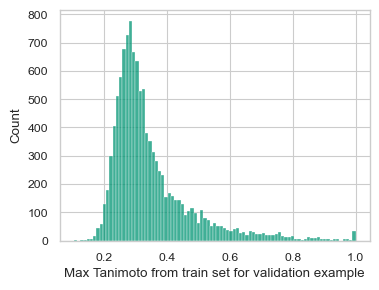

In [12]:
# Tanimoto similarity between train and validation molecules
max_train_tanimotos = []
for train_fp in fps['train']:
    max_train_tanimotos.append(max_tanimoto(train_fp, fps["val"]))

init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train set for validation example')
plt.show()

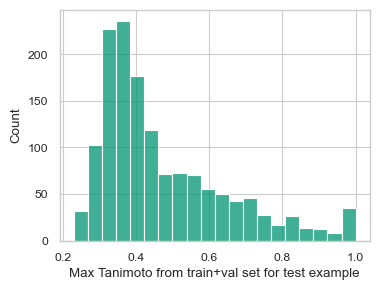

In [13]:
# tanimoto similarity between train+validation and test molecules
train_val_fps = pd.concat([pd.Series(fps['train']), pd.Series(fps['val'])])

max_train_tanimotos = []
for test_fp in fps['test']:
    max_train_tanimotos.append(max_tanimoto(test_fp, train_val_fps))

init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train+val set for test example')
plt.show()

In [14]:
split_tsv_path = "datasets/MSn_splits.tsv"
create_split_file(msn_dataset, train, validation, test, split_tsv_path)

split tsv file was created successfully at datasets/MSn_splits.tsv


In [18]:
tsv = pd.read_csv(split_tsv_path, sep="\t")
for fold in tsv["fold"]:
    if fold not in ["train", "val", "test"]:
        print(fold)

In [25]:
mspec_data_module = MassSpecDataModule(batch_size=2, dataset=msn_dataset, split_pth="datasets/MSn_splits.tsv")
mspec_data_module.prepare_data()
mspec_data_module.setup()
mspec_data_module.train_dataloader()
mspec_data_module.val_dataloader()

In [27]:
foo = mspec_data_module.val_dataloader()
next(iter(foo))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'torch_geometric.data.data.Data'>